In [1]:
pip install --upgrade diffusers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.8 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from diffusers import StableDiffusionPanoramaPipeline, DDIMScheduler

model_ckpt = "stabilityai/stable-diffusion-2-base"
scheduler = DDIMScheduler.from_pretrained(model_ckpt, subfolder="scheduler")
pipe = StableDiffusionPanoramaPipeline.from_pretrained(model_ckpt, scheduler=scheduler, torch_dtype=torch.float16)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-04-11 17:47:58.924960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 17:47:58.925101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 17:47:59.201296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
pipe = pipe.to("cuda")

prompt1 = "A 360-panoramic view of a indoor badminton court"

image1 = pipe(prompt1, width=1024, height=512,
    circular_padding=True).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

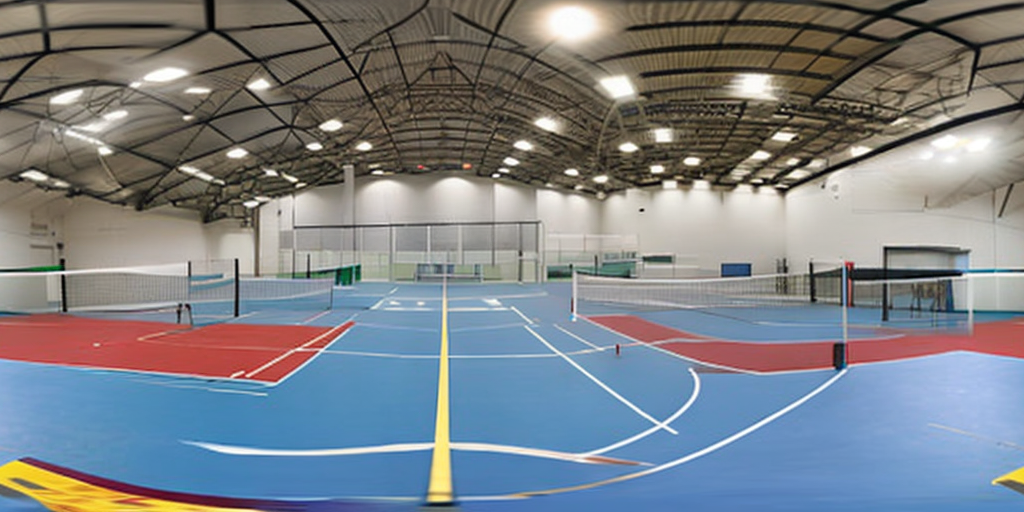

In [4]:
image1

  0%|          | 0/50 [00:00<?, ?it/s]

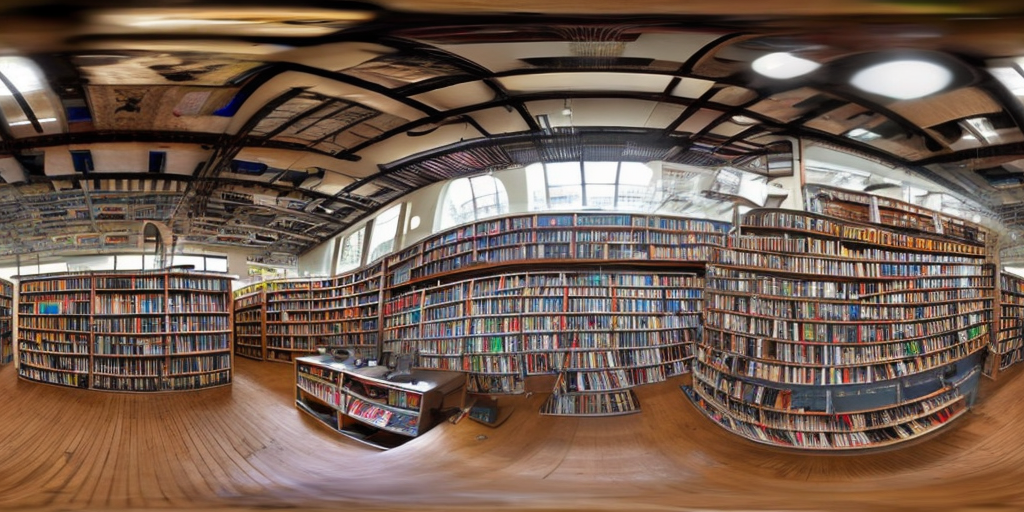

In [5]:
prompt2 = "A 360-panoramic view of a indoor library"

image2 = pipe(prompt2, width=1024, height=512,
    circular_padding=True).images[0]

image2

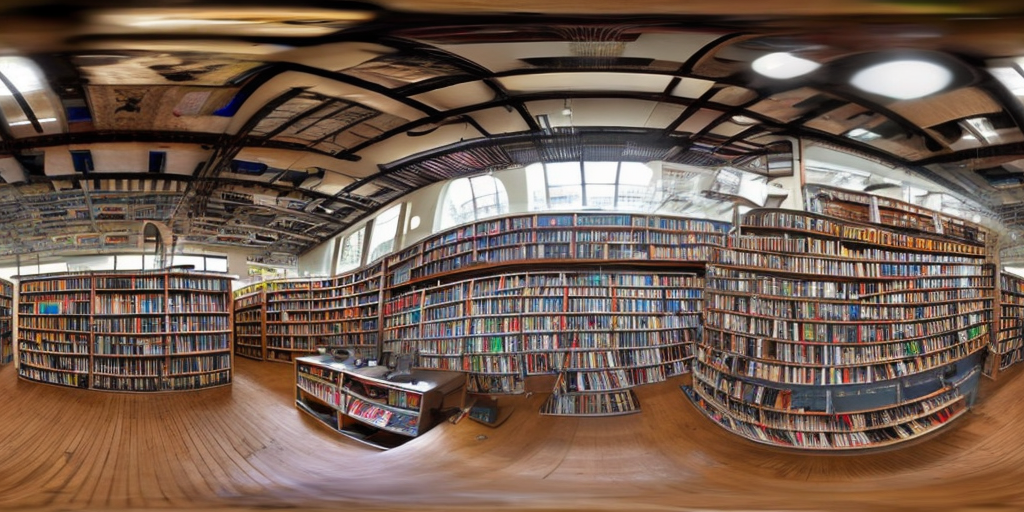

In [6]:
image2

  0%|          | 0/50 [00:00<?, ?it/s]

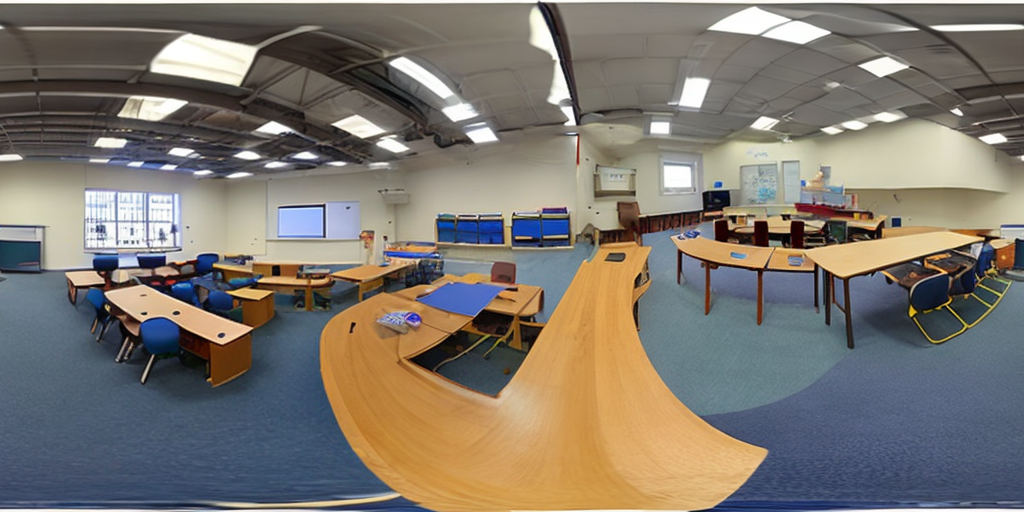

In [7]:
prompt3 = "A 360-panoramic view of a indoor classroom"

image3 = pipe(prompt3, width=1024, height=512,
    circular_padding=True).images[0]

image3

  0%|          | 0/50 [00:00<?, ?it/s]

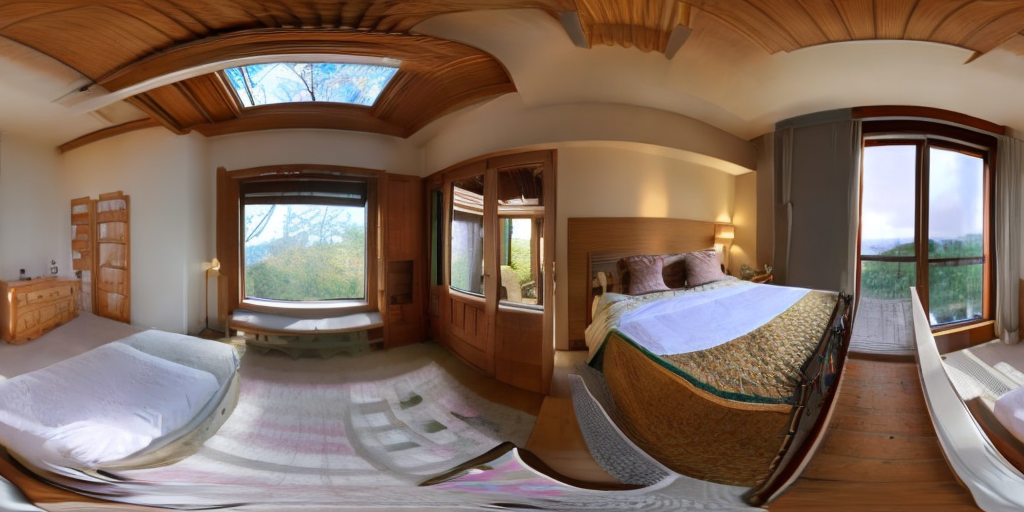

In [8]:
prompt4 = "A 360-panoramic view of a bedroom"

image4 = pipe(prompt4, width=1024, height=512,
    circular_padding=True).images[0]

image4

  0%|          | 0/50 [00:00<?, ?it/s]

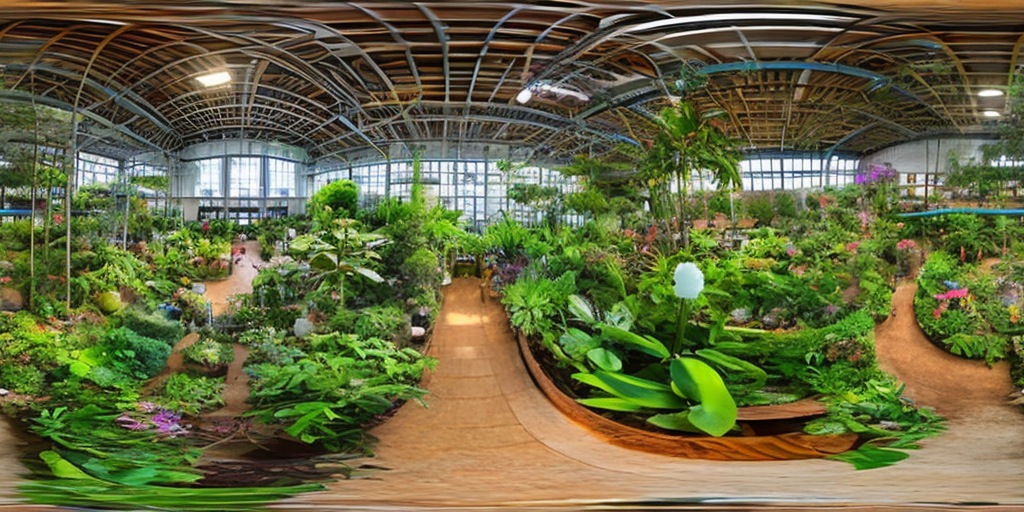

In [9]:
prompt5 = "A 360-panoramic view of a indoor botanical garden"

image5 = pipe(prompt5, width=1024, height=512,
    circular_padding=True).images[0]

image5

In [10]:
# pip install accelerate transformers safetensors diffusers

import torch
import numpy as np
from PIL import Image

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image


depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0-small",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
pipe.enable_model_cpu_offload()


def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image


config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/320M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [65]:
roomdepth= load_image('/kaggle/input/panodepth/pano_depth.png')

In [66]:
images4 = pipe(
    prompt4,
    image=image4,
    control_image=roomdepth,
    strength=0.99,
    
    num_inference_steps=50,
    controlnet_conditioning_scale=0.5,
).images

  0%|          | 0/49 [00:00<?, ?it/s]

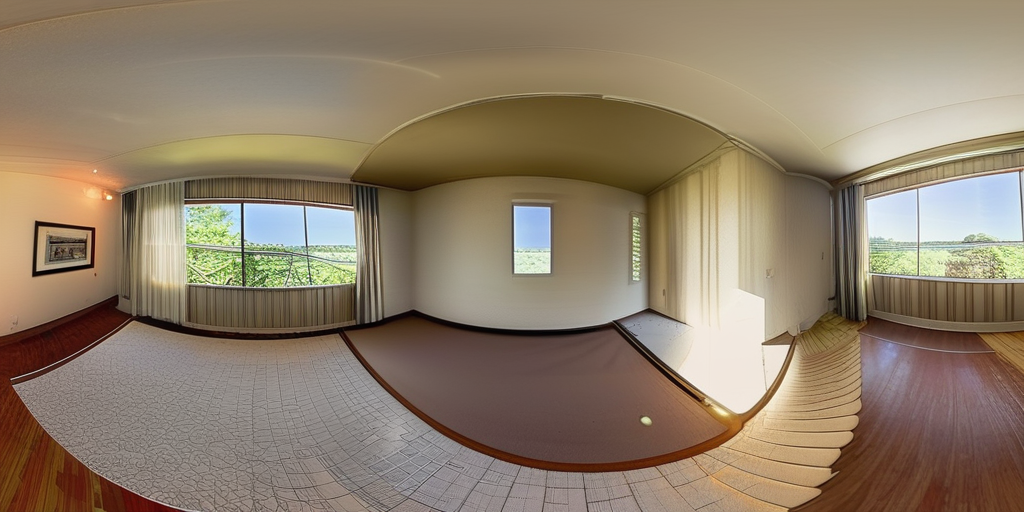

In [67]:
images4[0]

In [70]:
images3 = pipe(
    prompt3,
    image=image3,
    control_image=roomdepth,
    strength=0.99,
    circular_padding=True,
    num_inference_steps=50,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
).images

  0%|          | 0/49 [00:00<?, ?it/s]

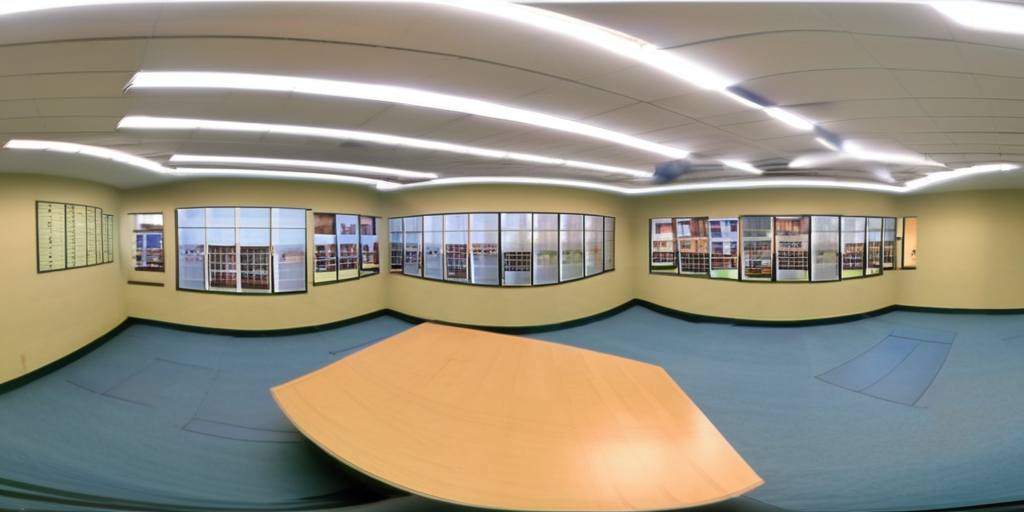

In [71]:
images3[0]